In [14]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime as dt
import io
import requests
import matplotlib.collections as col
import matplotlib.patches as mpatches
import seaborn as sns
import math
import scipy.stats as stats
import sklearn
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.regressionplots import *
import statsmodels.api as sm
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")
from statsmodels.formula.api import ols

In [15]:
#Going to make an automated tester to find the best binning for this model

In [16]:
allPolls = pd.read_csv('all_polls.csv')

In [17]:
errorPolls = allPolls[['samplesize', 'error', 'bias', 'pollster', 'state', 'type_simple', 'partisan_race']]

In [18]:
#Removing some outliers. errorPolls has all the most relevant columns from allPolls with the
#outliers trimmed out.
errorPolls = errorPolls[errorPolls['error'] < 90]
errorPolls.reset_index(drop = True, inplace = True)

In [19]:
pollerror = allPolls.groupby('pollster').mean()
pollerror = pollerror[['error']]
pollstd = allPolls.groupby('pollster').std()
pollstd = pollstd[['error']]
pollerror.rename(columns = {'error':'pollster_error'}, inplace = True)
pollstd.rename(columns = {'error':'pollster_std'}, inplace = True)

In [20]:
#Make and return the binned data we'll be using
def makeBins(binSize, pollerror, pollstd):
    binData = pd.DataFrame()
    binData['samplesize'] = range(0, 4000, binSize)
    binData['error'] = 0
    binData['pos_bias'] = 0
    binData['neg_bias'] = 0
    binData['pollster'] = ''
    binData['type_simple'] = ''
    binData['state'] = ''
    binData['partisan_race'] = 0
    binData = errorPopulate(binSize, binData, errorPolls)
    binData = binData.merge(pollerror, how = 'left', left_on = 'pollster', right_on = 'pollster')
    binData = binData.merge(pollstd, how = 'left', left_on = 'pollster', right_on = 'pollster')
    binData = binData[binData['error'] != 0]
    binData['log_error'] = np.log(binData['error'])
    binData.dropna(inplace = True)
    return binData

In [21]:
def errorPopulate(binSize, binData, errorPolls):
    for entry in range(len(errorPolls)):
        currentError = errorPolls['error'][entry]
        #Round sample size to the nearest binSize
        sampleSize = (errorPolls['samplesize'][entry] + 
                      (binSize - errorPolls['samplesize'][entry]) % binSize)
        #Make sure we don't go over
        if sampleSize in binData['samplesize'].values:
            if binData['error'][sampleSize/binSize] < currentError:
                binData['error'][sampleSize/binSize] = currentError
                binData['pollster'][sampleSize/binSize] = errorPolls['pollster'][entry]
                binData['type_simple'][sampleSize/binSize] = errorPolls['type_simple'][entry]
                binData['state'][sampleSize/binSize] = errorPolls['state'][entry]
                binData['partisan_race'][sampleSize/binSize] = errorPolls['partisan_race'][entry]
    return binData

In [22]:
#Test binnings from 1-100, return R-squared values, F values as tuples
def calculate_best_binning(pollerror, pollstd):
    binScores = []
    for binSize in range(100):
        #We don't want bins of 0
        binData = makeBins(binSize+1, pollerror, pollstd)
        x = binData[['samplesize', 'pollster_std']]
        y = binData['log_error']
        testModel = sm.OLS(y, x).fit()
        binScores.append((testModel.rsquared_adj, testModel.fvalue))
    return binScores

In [25]:
 binData = makeBins(1, pollerror, pollstd)
x = binData[['samplesize', 'pollster_std']]
y = binData['log_error']
testModel = sm.OLS(y, x).fit()
print(testModel.rsquared_adj, testModel.fvalue)

C:\Users\marcu\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\marcu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\marcu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

0.8165235541408629 2993.820618409555


C:\Users\marcu\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [26]:
binScores = calculate_best_binning(pollerror, pollstd)

C:\Users\marcu\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\marcu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\marcu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

In [27]:
rsquared_adj = []
f_score = []
for x in binScores:
    rsquared_adj.append(x[0])
    f_score.append(x[1])

Text(0.5, 1.0, 'F-statistic at varying bin sizes')

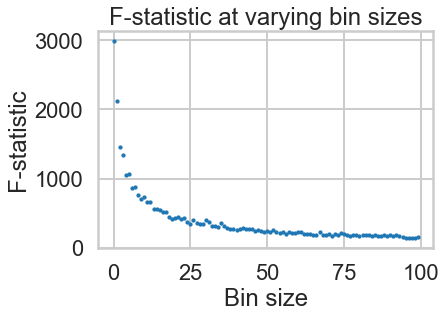

In [30]:
plt.scatter(y= f_score, x = range(100), s = 5)
plt.xlabel('Bin size')
plt.ylabel('F-statistic')
plt.title('F-statistic at varying bin sizes')

Text(0.5, 1.0, 'R-squared at varying bin sizes')

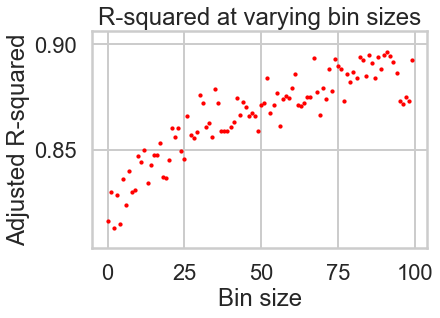

In [31]:
plt.scatter(y= rsquared_adj, x = range(100), s = 5, c = 'red')
plt.xlabel('Bin size')
plt.ylabel('Adjusted R-squared')
plt.title('R-squared at varying bin sizes')

In [32]:
test = []
for x in range(len(rsquared_adj)):
    test.append(rsquared_adj[x] * f_score[x])

Text(0.5, 1.0, 'Multiplying R-squared by F-statistic')

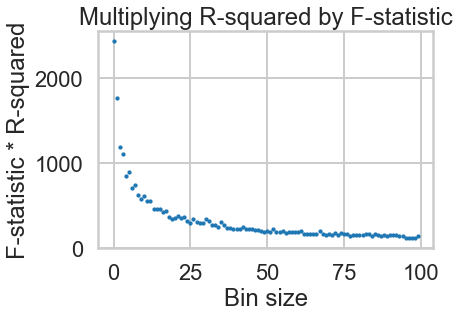

In [33]:
plt.scatter(y = test, x = range(100), s = 5)
plt.xlabel('Bin size')
plt.ylabel('F-statistic * R-squared')
plt.title('Multiplying R-squared by F-statistic')

In [36]:
print(f_score[12])

655.7712418491627


In [38]:
print(rsquared_adj[12])

0.8500528207145275


In [152]:
errorPolls = errorPolls.merge(pollstd, how = 'left', left_on = 'pollster', right_on = 'pollster')

In [153]:
errorPolls['log_error'] = np.log(errorPolls['error'])
errorPolls.dropna(inplace = True)
#Remove -inf in the logs
errorPolls = errorPolls[errorPolls['log_error'] > -100]

In [154]:
x = errorPolls[['samplesize', 'pollster_std']]
y = errorPolls['log_error']
testModel = sm.OLS(y, x).fit()
print(testModel.summary())

                                 OLS Regression Results                                
Dep. Variable:              log_error   R-squared (uncentered):                   0.516
Model:                            OLS   Adj. R-squared (uncentered):              0.516
Method:                 Least Squares   F-statistic:                              5349.
Date:                Sun, 01 Mar 2020   Prob (F-statistic):                        0.00
Time:                        16:24:51   Log-Likelihood:                         -15959.
No. Observations:               10038   AIC:                                  3.192e+04
Df Residuals:                   10036   BIC:                                  3.194e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [131]:
x = errorPolls[['samplesize', 'pollster_std']]
y = errorPolls['log_error']
print(type(y[83]))

<class 'numpy.float64'>


In [105]:
for x in errorPolls['samplesize']:
    if type(x) != float:
        print(x)

In [110]:
print(len(errorPolls['samplesize']), len(errorPolls['pollster_std']))

10060 10060


In [112]:
print(len(errorPolls['log_error']))

10060


In [136]:
print(np.log(0))

-inf


C:\Users\marcu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [114]:
testModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              log_error   R-squared (uncentered):                     nan
Model:                            OLS   Adj. R-squared (uncentered):                nan
Method:                 Least Squares   F-statistic:                                nan
Date:                Sun, 01 Mar 2020   Prob (F-statistic):                         nan
Time:                        16:11:27   Log-Likelihood:                             nan
No. Observations:                 100   AIC:                                        nan
Df Residuals:                      98   BIC:                                        nan
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
samplesize         -inf        nan        nan        nan         nan         nan
pollster_std        inf        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         59.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
print(f_score[:20])

NameError: name 'f_score' is not defined